In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import mapclassify.classifiers as classifiers
import pylab as pylab
import numpy as np
import seaborn as sn


In [ ]:
# Get the CLIMI-index

CLIMI = pd.read_excel('CLIMI 2010.xlsx')
CLIMI.drop(["Input"], axis=1, inplace=True)

In [3]:
# Plot a map with Geopandas

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Correct for the discrepancies between country names

world.name.replace(["United States of America","Macedonia", "Dem. Rep. Congo", "Guinea-Bissau","Dominican Rep.","Côte d'Ivoire","Kyrgyzstan","Czechia","Slovakia"],
                   ["United States","United States","Bosnia and Herzegovina","DR Congo","Guinea Bissau","Dominican Republic","Cote d'Ivoire","Kyrgyz Republic","Czech Republic","Slovak Republic"])


data = world.merge(CLIMI , how= "left", right_on= "Country", left_on= "name") 

# Antarctica isn't needed for plotting

data.drop(data[data.name=="Antarctica"].index, inplace=True)


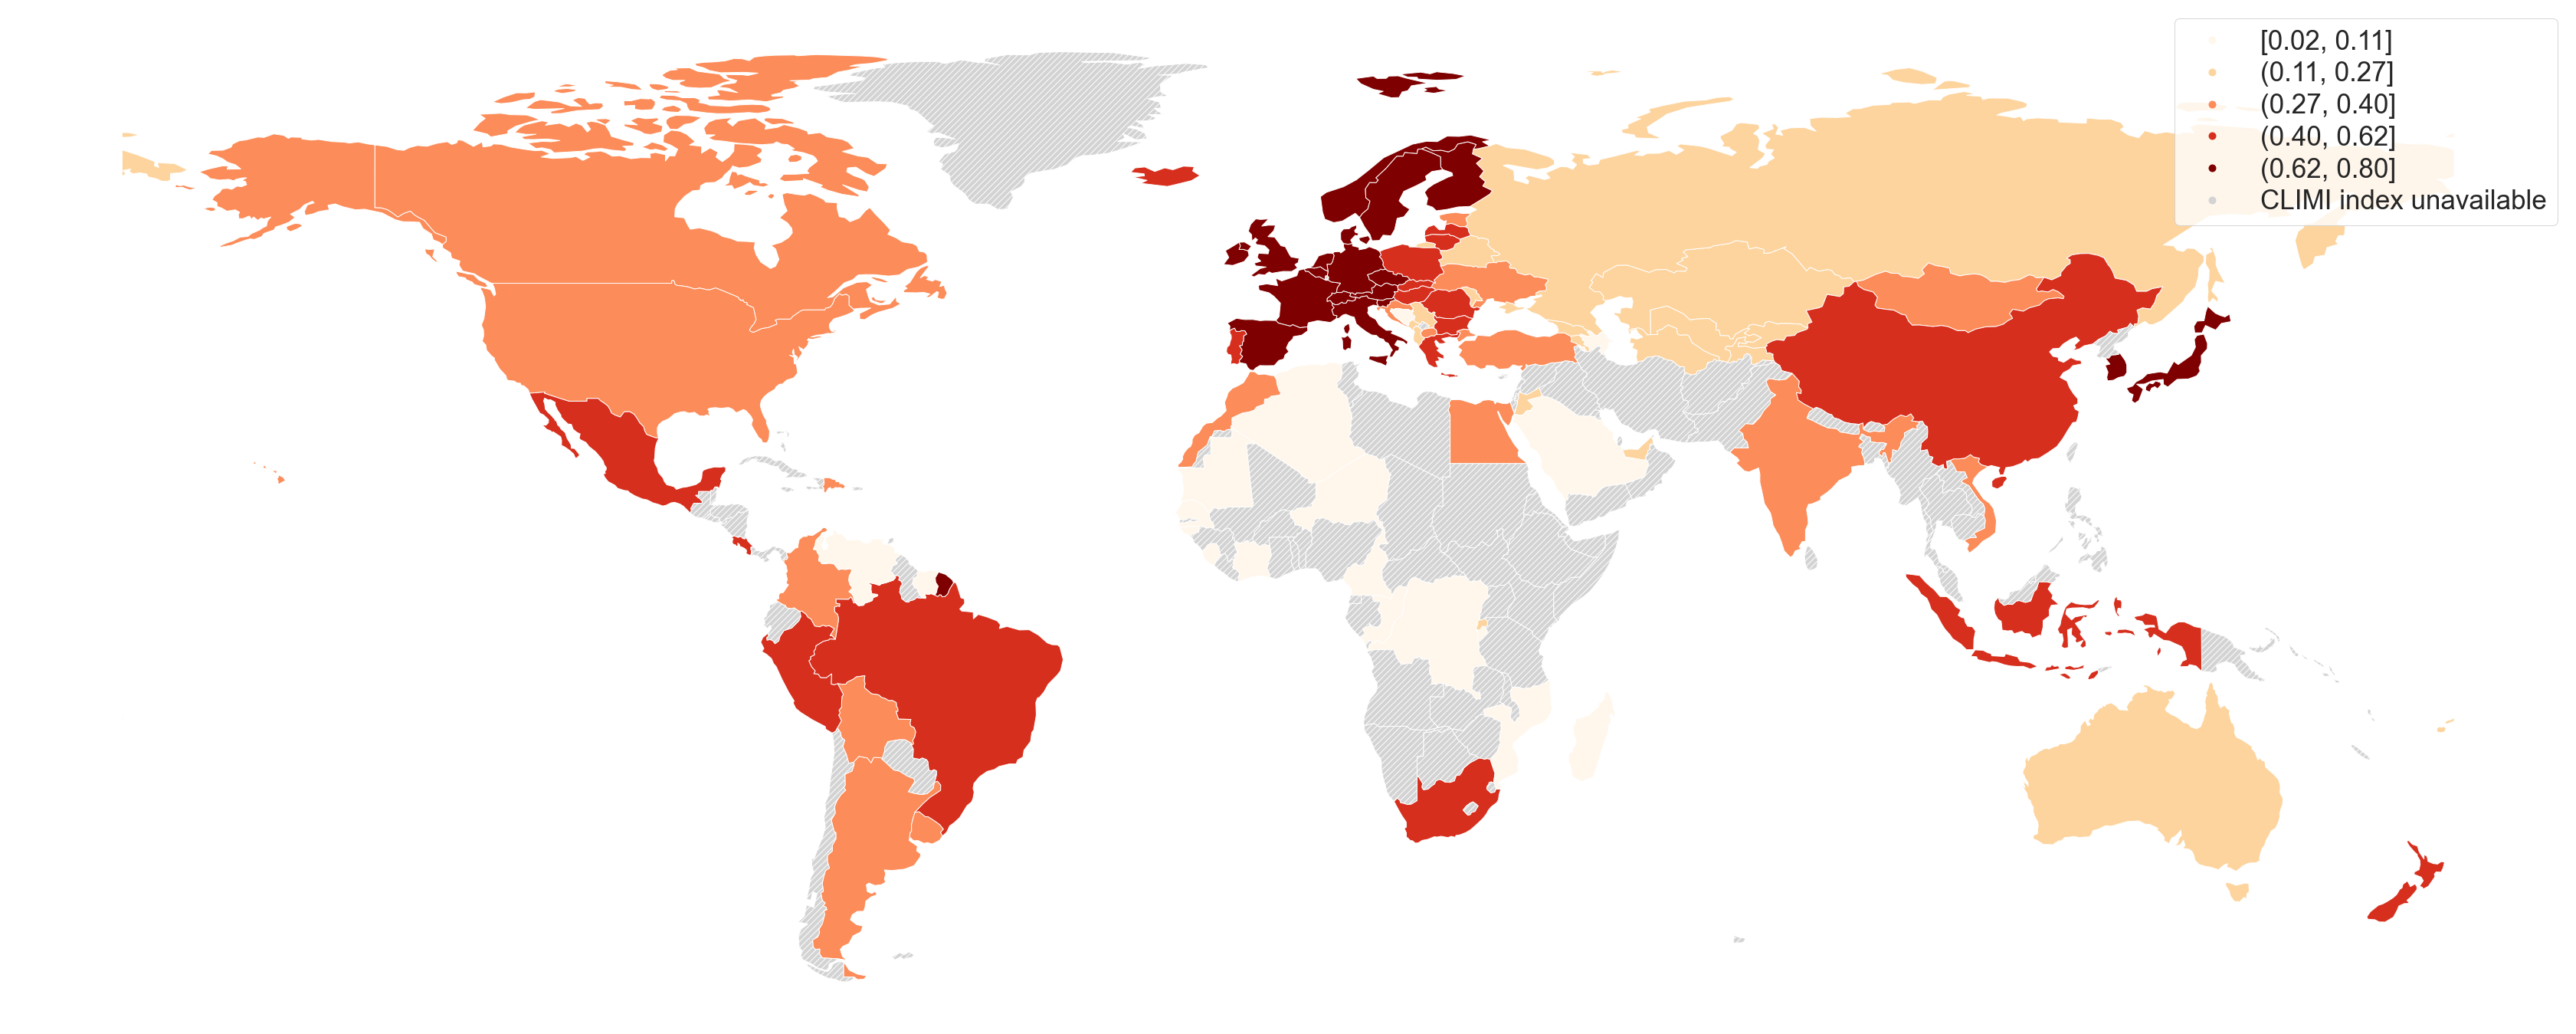

In [48]:
# Plot the world map

params = {'legend.fontsize': 35,
          'legend.handlelength': 2,
         'legend.labelspacing':0.25}

pylab.rcParams.update(params)

ax= data.plot(column='CLIMI', cmap ='OrRd', figsize=(60,80),   scheme='quantiles', k=5, legend =  
              
           True,  missing_kwds={"color": "lightgrey",
           #"edgecolor": "grey",
           "hatch": "///",
          "label": "CLIMI index unavailable" })


ax.set_axis_off()

plt.savefig("map.jpg", bbox_inches='tight') 

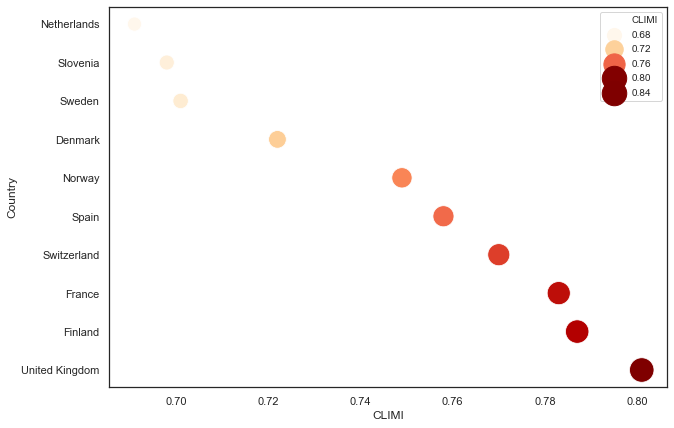

In [47]:
#  Top 10 scoring countries on the CLIMI-index

plt.figure(figsize=(10,7))

sn.set(style="white")

params = {'legend.fontsize': 10,
          'legend.handlelength': 2,
         'legend.labelspacing':0.55}

pylab.rcParams.update(params)

sn.scatterplot(y=df.index[:10], x=df.CLIMI[:10], size=df.CLIMI[:10],hue=df.CLIMI[:10], sizes=(200,600),palette='OrRd')

plt.savefig("scatter")

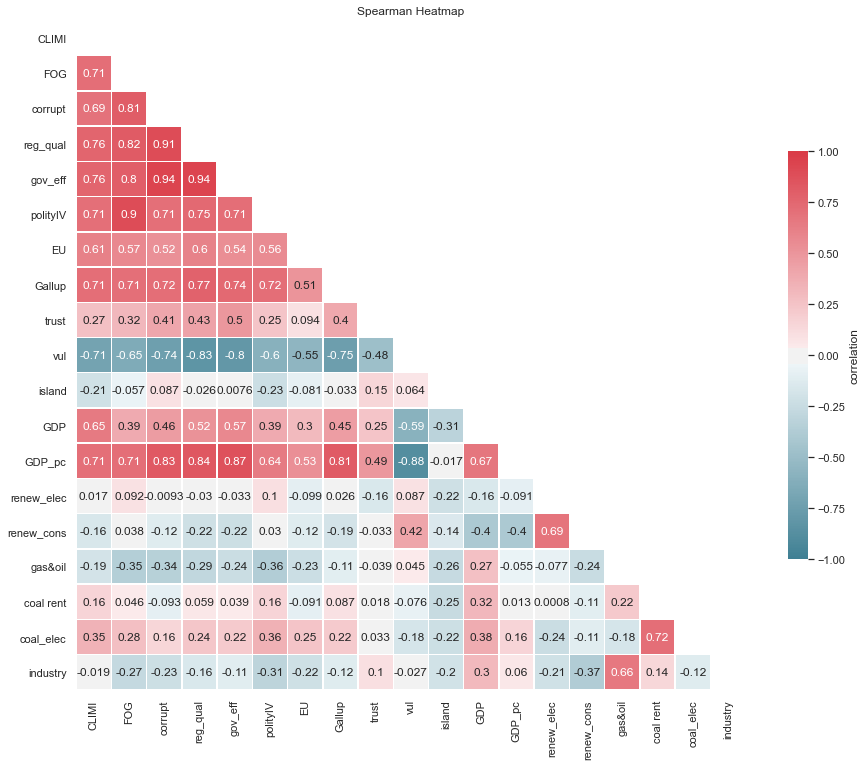

In [9]:
## Use the self-defined package "Get_data" to get the dataset which consists of 17 features.

df = get_dataset()

df = df.merge(CLIMI, on="Country", how="right")

df = df.set_index("Country")

df = df.apply(lambda x: x.astype(float) 
              if x.name == 'fossil_GDP' or x.name == 'GDP' or x.name ==" trust" else x)

df=df.rename(columns= {"coal%elec" : "coal_elec",
                       "elec": "renew_elec",
                       "cons": "renew_cons",
                       "control_cor": "corrupt",
                       "small island" : "island", 
                       "vulnerability" : "vul",
                       "gas&oil rent": "gas&oil",
                       "fossil_GDP" : "industry"})

## Heatmap and correlation matrix

corrMatrix=df.corr("spearman")

# Create a mask

sn.set(style="white")

mask = np.zeros_like(corrMatrix, dtype=np.bool)

mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15,15))

# Generate a custom diverging colormap

cmap = sn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio

sn.heatmap(corrMatrix, mask=mask, cmap=cmap, center=0, vmax=1, vmin =-1, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5, "label": "correlation"} )

bottom, top = ax.get_ylim()

ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title("Spearman Heatmap")
plt.savefig("BEFORE_Heatmap", bbox_inches='tight', dpi=200)                   



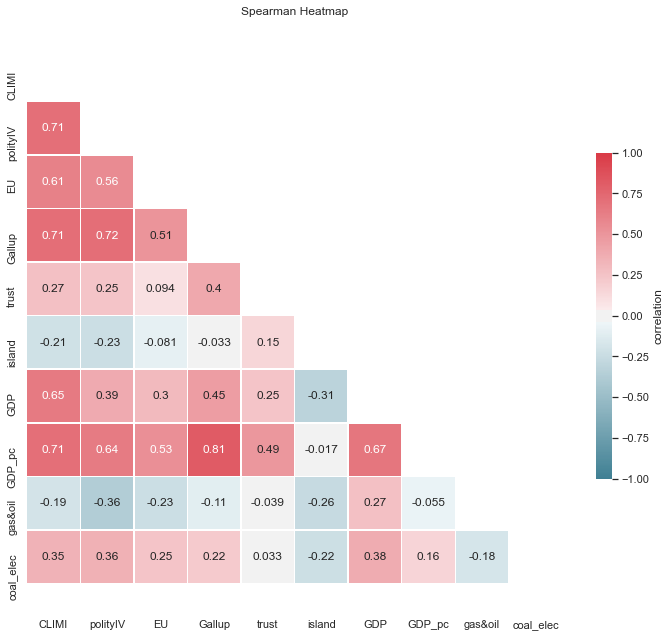

In [10]:
# After the feature selection plot again the heatmap.

corrMatrix=df.drop(["renew_elec","corrupt","renew_cons", "coal rent" , "industry","gov_eff", "FOG", "reg_qual", "vul"], axis=1).corr(method="spearman")

plt.figure(figsize=(12,12))

sn.set(style="white")

mask = np.zeros_like(corrMatrix, dtype=np.bool)

mask[np.triu_indices_from(mask)] = True

ax=sn.heatmap(corrMatrix, mask= mask , cmap=sn.diverging_palette(220, 10, as_cmap=True), center=0, vmax=1, vmin =-1, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5, "label": "correlation"})

bottom, top = ax.get_ylim()

ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title("Spearman Heatmap")

plt.savefig("AFTER_Heatmap", bbox_inches='tight', dpi=200)                   

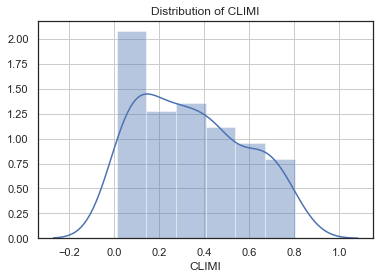

In [12]:
# Distribution of the outcome variable

plt.tight_layout()

sn.distplot(df.CLIMI)

plt.title("Distribution of CLIMI")

plt.grid(True)



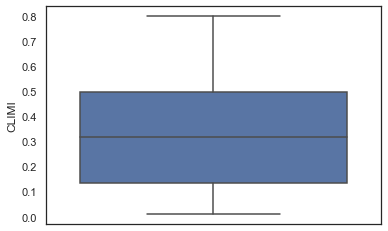

In [13]:
# Outliers --> no outliers in the target variable

sn.boxplot(y=df.CLIMI)


In [15]:
# Missing values 
df.isna().sum()

CLIMI          0
FOG            0
corrupt        0
reg_qual       0
gov_eff        0
polityIV       7
EU             0
Gallup        18
trust         31
vul            2
island         2
GDP            0
GDP_pc         0
renew_elec     0
renew_cons     0
gas&oil        0
coal rent      0
coal_elec     10
industry       0
dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from missingpy import MissForest
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from dtreeviz.trees import *
from sklearn.tree import DecisionTreeRegressor
from pdpbox import pdp, get_dataset, info_plots


In [17]:
# Keep the best feature subset

X = df.drop(["renew_elec","corrupt","renew_cons", "coal rent" , "industry","gov_eff", "FOG", "reg_qual", "vul", "CLIMI"], axis=1)

y = df['CLIMI']

#Train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)



In [18]:
## Simple Imputation with median

median_imputer = SimpleImputer(strategy="median", axis=0)

# Impute for the training set

X_train = median_imputer.fit(X_train)

# Impute for the training set

X_test = median_imputer.fit(X_test)

# From a Data Science perspective, it is important to first split into training and test set, then replace the missing values.

/Users/ececaliskan/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [118]:
### Dimensionality Reduction with Lasso

lasso = Lasso()

lasso.fit(X_train,y_train)

train_score=lasso.score(X_train,y_train)

test_score=lasso.score(X_test,y_test)

coeff_used = np.sum(lasso.coef_!=0)

print ("training score:" + "{:.3f}".format(train_score))
print ("test score: "+ "{:.3f}".format(test_score))
print ("number of features used: ", coeff_used)

coefficients = pd.DataFrame(lasso.coef_, index = X_train.columns,columns=['coefficient estimate']).sort_values('coefficient estimate', ascending=False)

print(coefficients)


training score: 0.2995786010012007
test score:  0.32770019691181307
number of features used:  4
            coefficient estimate
Gallup              1.958431e-03
GDP                 1.181955e-05
GDP_pc              2.361843e-06
trust               3.557424e-08
fossil_GDP         -0.000000e+00
renewmix            0.000000e+00
EU                  0.000000e+00
coal rent          -0.000000e+00
polityIV            0.000000e+00


In [119]:
# Linear Regression

linear = LinearRegression()

linear.fit(X_train,y_train)

train_score=linear.score(X_train,y_train)

test_score=linear.score(X_test,y_test)

print ("training score:" + "{:.3f}".format(train_score))
print ("test score: "+ "{:.3f}".format(test_score))

coefficients = pd.DataFrame(linear.coef_, index = X_train.columns,columns=['coefficient estimate']).sort_values('coefficient estimate', ascending=False
                                                                                                               )
print(coefficients)


training score: 0.5758260066183108
test score:  0.6148413978169489
            coefficient estimate
EU                  2.330067e-01
polityIV            8.266073e-03
Gallup              2.168239e-03
fossil_GDP          1.844538e-03
coal rent           1.784445e-03
renewmix            6.389160e-04
GDP                 1.085793e-05
GDP_pc              6.031177e-07
trust               3.423661e-08


In [84]:
# Compare it to Ridge Regression

ridge = Ridge()

ridge.fit(X_train,y_train)

train_score=ridge.score(X_train,y_train)

test_score=ridge.score(X_test,y_test)

print ("training score:" + "{:.3f}".format(train_score))
print ("test score: "+ "{:.3f}".format(test_score))

coefficients = pd.DataFrame(ridge.coef_, index = X_train.columns,columns=['coefficient estimate']).sort_values('coefficient estimate', ascending=False)

print(coefficients)


# Unexpected negative coefficients -> Endogenity or reverse causality (policies might affect environ. awareness)! or multicollinearity (Gallup is also correlated with institutional variables)

#  Ridge displays similar importance for correlated variables. Lasso does not work well with multicollinearity. With correlated variables; one variable is kept, the others coefficient is lowered to zero.

# Multicollinearity affects the coefficients and p-values, but it does not influence the predictions, precision of the predictions, and the goodness-of-fit statistics.


training score: 0.5788966882535838
test score:  0.5623294648289047
            coefficient estimate
EU                  2.106079e-01
polityIV            8.630181e-03
Gallup              2.351573e-03
fossil_GDP          1.657961e-03
coal rent           1.002128e-03
renewmix            5.566261e-04
GDP                 9.847141e-06
GDP_pc              6.112306e-07
trust               3.591261e-08


In [122]:
# Library "statsmodels" gives better regression summary output

model = sm.OLS(y_train, X_train).fit()

predictions = model.predict(X_test)

print_model = model.summary()

print(print_model)

In [ ]:
# Does MissForest bring any improvement over median-NA-imputation? 

imputer = MissForest()

X_train_imputed = imputer.fit_transform(X_train)

X_test_imputed = imputer.fit_transform(X_test)

# Change from ndarray to dataframe

X_train_imputed = pd.DataFrame(X_train_imputed) 

X_test_imputed = pd.DataFrame(X_test_imputed)

# Use the best feature subset

X_train_imputed = X_train_imputed.drop([ "renewmix2","coalmix", "gov_eff", "FOG", "reg_qual", "co2", "gas&oil rent", "control_cor"], axis=1)

X_test_imputed = X_test_imputed.drop([ "renewmix2","coalmix", "gov_eff", "FOG", "reg_qual", "co2", "gas&oil rent", "control_cor"], axis=1)



In [23]:
#### Random Forest

# RF instance with 1000 trees

rf = RandomForestRegressor( n_estimators= 1000,random_state = 42)

# Train the model on training data

rf.fit(X_train, y_train); 

# Performance Metrics

predictions = rf.predict(X_test)

print('Mean Absolute Error:'+ "{:.3f}".format(metrics.mean_absolute_error(y_test, predictions)))  
print('Mean Squared Error:' + "{:.3f}".format(metrics.mean_squared_error(y_test, predictions))) 
print('Root Mean Squared Error:'+ "{:.3f}".format(np.sqrt(metrics.mean_squared_error(y_test, predictions))))
print('R squared test:'+ "{:.3f}".format(metrics.r2_score(y_test, predictions)))
print('R squared training :'+ "{:.3f}".format(rf.score(X_train, y_train)))


#In all feature selection procedures, it is a good practice to select the features by examining only the training set. This is to avoid overfitting.

# Correlated features will show in a tree similar and lowered importance, compared to what their importance would be if the tree was built without correlated counterparts.

# In situations like this, it is better to select features recursively, rather than all together as I have done here.

# The presence of correlated predictors has been shown to impact ability of RF to identify strong predictors

Mean Absolute Error:0.103
Mean Squared Error:0.015
Root Mean Squared Error:0.121
R squared test:0.768
R squared training :0.956


In [27]:
### Feature Importances

feature_importances = pd.DataFrame(rf.feature_importances_, index = X_train.columns,columns=['importance']).sort_values('importance', ascending=False)
feature_importances

importance
GDP_pc       0.395750
GDP          0.156339
polityIV     0.121473
Gallup       0.087907
gas&oil      0.082714
EU           0.069103
coal_elec    0.048897
trust        0.035141
island       0.002675

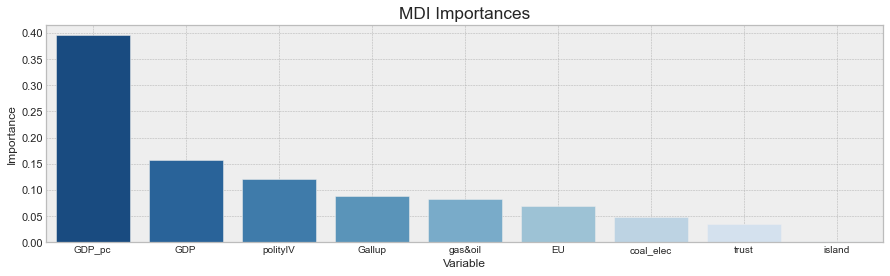

In [36]:
### 1-) Mean Decrease Impurity (MDI) Importance Scores

plt.style.use('bmh')

plt.figure(figsize=(15,4))

params = {'axes.labelsize': 'medium',
         'xtick.labelsize':'small',}

pylab.rcParams.update(params)

sn.barplot(feature_importances.index,feature_importances.importance, palette="Blues_r")

plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('MDI Importances'); plt.grid(True)

plt.savefig("MDI_importance",bbox_inches='tight', dpi=200)



In [29]:
### 2-) Permutation Importance Scores

from sklearn.inspection import permutation_importance

perm = permutation_importance(rf, X_test, y_test, random_state=42, n_jobs=-1, n_repeats=10)

perm.importances_mean

permutation_importances = pd.DataFrame(perm.importances_mean, index = X_test.columns, columns=['importance']).sort_values('importance', ascending=False)

permutation_importances


importance
GDP_pc       0.234365
GDP          0.150530
gas&oil      0.146615
polityIV     0.074376
Gallup       0.039055
EU           0.030254
coal_elec    0.009771
island      -0.003056
trust       -0.010763

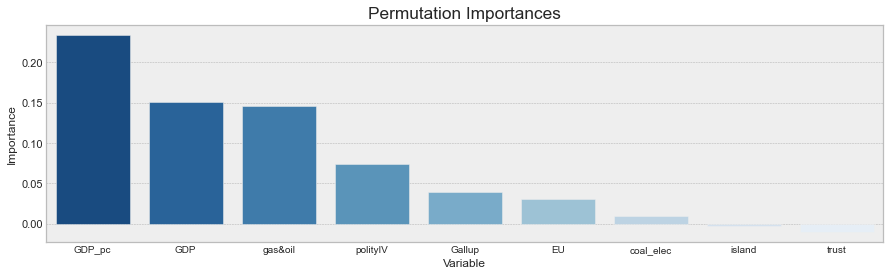

In [37]:
plt.style.use('bmh')

plt.figure(figsize=(15,4))

params = {'axes.labelsize': 'medium',
         'xtick.labelsize':'small',}

pylab.rcParams.update(params)

sn.barplot(permutation_importances.index,permutation_importances.importance, palette="Blues_r")

# plt.xticks(x_values, feature, rotation='vertical') 

plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Permutation Importances');

plt.savefig("perm_importance",bbox_inches='tight', dpi=200)

In [60]:
# Compare the importance scores with Plotly

imp = permutation_importances.merge(feature_importances, left_on=permutation_importances.index, right_on= feature_importances.index, how="inner")

imp = imp.rename(columns = {"key_0": "feature", "importance_x" : "permutation importance", "importance_y" :"MDI importance"})
imp

import plotly.graph_objs as go
import plotly.offline as pyo

# Set notebook mode to work in offline

pyo.init_notebook_mode()

perm = go.Bar(
    x = imp.feature, 
    y = imp["permutation importance"],
    name= "permutation importance",
    marker_color="mediumturquoise")
MDI = go.Bar(
    x = imp.feature, 
    y = imp["MDI importance"],
    name = "MDI importance",
    marker_color="indianred")

fig = go.Figure(data= [perm, MDI])

fig.update_layout(
   title="Feature Importances Compared",
   xaxis_title="year",
   showlegend=True)

fig.show()


In [113]:
# Current hyperparamaters of the forest

print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [126]:
### Random Search Cross-Validation for Tuning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [127]:
rf = RandomForestRegressor() 

# Random search of parameters, using 3 fold cross validation, search across 1000 different combinations, and use all available cores (n_jobs = -1)

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 1000, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model

rf_random.fit(X_train, y_train)



Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 32.8min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 41.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 47.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=1000,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [128]:
# Best hyperparameters for the random forest

rf_random.best_params_ 

#'n_estimators': 200,
# 'min_samples_split': 2,
# 'min_samples_leaf': 1,
# 'max_features': 'sqrt',
# 'max_depth': 10,
# 'bootstrap': False}

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}

In [121]:
# Performance Metrics with the best model

yhat = rf_random.predict(X_test)


print('Mean Absolute Error:'+ "{:.3f}".format(metrics.mean_absolute_error(y_test, predictions)))  
print('Mean Squared Error:' + "{:.3f}".format(metrics.mean_squared_error(y_test, predictions))) 
print('Root Mean Squared Error:'+ "{:.3f}".format(np.sqrt(metrics.mean_squared_error(y_test, predictions))))
print('R squared test:'+ "{:.3f}".format(metrics.r2_score(y_test, predictions)))
print('R squared training :'+ "{:.3f}".format(rf.score(X_train, y_train)))


In [115]:
### Hyper-parameter tuning for decision-tree

from sklearn.model_selection import RandomizedSearchCV

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(4, 110, num = 20)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2,3,4, 5,6,7,8,10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3,4,5,6]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}



In [116]:
dt = DecisionTreeRegressor() 

# Random search of parameters, using 3 fold cross validation, search across 600 different combinations, and use all available cores

dt_random = RandomizedSearchCV(estimator = dt, param_distributions = random_grid, n_iter = 600, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
dt_random = dt_random.fit(X_train, y_train)

# n_iter is the number of different combinations to be tried for

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 928 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:   12.1s finished


In [117]:
# Best hyperparameters for the decision tree

dt_random.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 87,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [118]:
### Decision-tree 

predictions = dtree_rnadom.predict(X_test)

# Performance Metrics

print('Mean Absolute Error:' + "{:.3f}".format(metrics.mean_absolute_error(y_test, predictions))) 
print('Mean Squared Error:' + "{:.3f}".format(metrics.mean_squared_error(y_test, predictions)))  
print('Root Mean Squared Error:'+ "{:.3f}".format(np.sqrt(metrics.mean_squared_error(y_test, predictions))))
print('R squared test:'+ "{:.3f}".format(metrics.r2_score(y_test, predictions)))
print('R squared training :' + "{:.3f}".format(dtree.score(X_train, y_train)))

In [53]:
### Visualize the decision-tree

# Option 1-) "dtreeviz" 

from dtreeviz.trees import *

dtree=tree.DecisionTreeRegressor(max_leaf_nodes = 9, max_depth=6, random_state = 42)

dtree.fit(X_train,y_train)

predictions =dtree.predict(X_test)

viz = dtreeviz(dtree,
              X_train,
              y_train,
              feature_names= ['polityIV', 'EU', 'Gallup', 'trust', 'island', 'GDP', 'GDP_pc','gas&oil', 'coal_elec'], 
            target_name= 'CLIMI', fancy="false")  
              
viz.view() 

# 1 conda install graphviz solves the path problem


In [ ]:
# Option 2-) "Graphviz"

import graphviz 

dot_data = tree.export_graphviz(dtree, out_file=None) 

graph = graphviz.Source(dot_data) 

graph.render("CLIMI") 

dot_data = tree.export_graphviz(dtree, out_file=None, 
      feature_names= ['polityIV', 'EU', 'Gallup', 'trust', 'island', 'GDP', 'GDP_pc',
      'gas&oil', 'coal_elec'],    
      filled=True, rounded=True,  
      special_characters=True)  

graph = graphviz.Source(dot_data)  

graph 

In [51]:
### Feature Selection based on Wrapper methods 

# Recursive Feature Elimination Cross-Validation

from sklearn.model_selection import KFold

from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=rf, step=1, cv=KFold(5))

rfecv.fit(X_train, y_train)




RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestRegressor(n_estimators=1000, random_state=42))

In [ ]:
### Plot the RFECV importance scores

dset = pd.DataFrame()

dset['attr'] = X_train.columns

dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 6))
params = { 'axes.labelsize': 'medium',
         'xtick.labelsize':'medium',}
pylab.rcParams.update(params)

sn.barplot(x=dset['attr'],y=dset['importance'], palette='Blues')

plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)

plt.xlabel('Importance', fontsize=14, labelpad=20)

plt.savefig("RFECV importance")

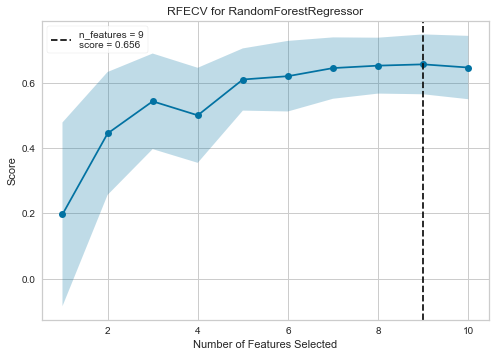

<Figure size 576x396 with 0 Axes>

In [172]:
### Visualize the number of features selected 

from yellowbrick.model_selection import RFECV

visualizer = RFECV(RandomForestRegressor( n_estimators= 500,random_state = 42))

visualizer.fit(X_train, y_train)       

visualizer.show()                       

plt.savefig("features selected",bbox_inches='tight', dpi=200)

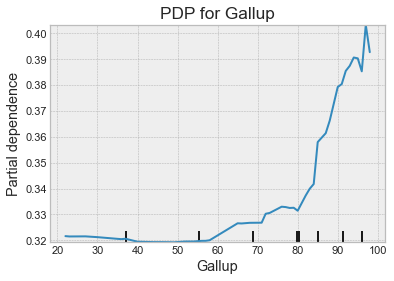

In [54]:
### Partial Dependency Plots

from sklearn.inspection import plot_partial_dependence

plt.style.use('bmh')

y_plots = plot_partial_dependence(rf,       
                            features=['Gallup'], 
                            X=X_train, 
                            feature_names=['polityIV', 'EU', 'Gallup', 'trust', 'island', 'GDP', 'GDP_pc',
                            'gas&oil', 'coal_elec']) 


plt.title('PDP for Gallup');

plt.savefig("Gallup",bbox_inches='tight', dpi=200)


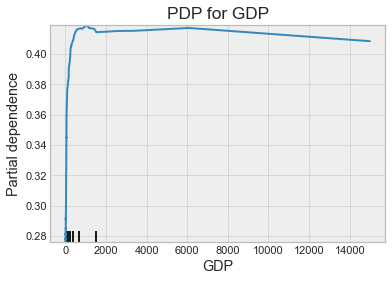

In [55]:
y_plots = plot_partial_dependence(rf,       
                            features=['GDP'], 
                            X=X_train, 
                            feature_names=['polityIV', 'EU', 'Gallup', 'trust', 'island', 'GDP', 'GDP_pc',
                            'gas&oil', 'coal_elec']) 

plt.title('PDP for GDP');

plt.savefig("GDP",bbox_inches='tight', dpi=200)



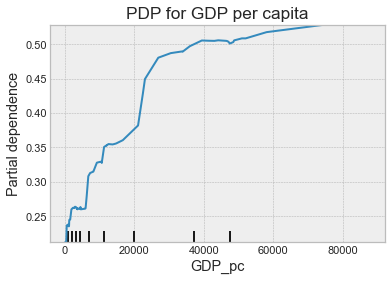

In [56]:
y_plots = plot_partial_dependence(rf,       
                            features=['GDP_pc'], 
                            X=X_train, 
                            feature_names=['polityIV', 'EU', 'Gallup', 'trust', 'island', 'GDP', 'GDP_pc',
                                    'gas&oil', 'coal_elec']) 

plt.title('PDP for GDP per capita');

plt.savefig("GDP_pc",bbox_inches='tight', dpi=200)



In [ ]:
y_plots = plot_partial_dependence(rf,       
                            features=['PolityIV'], 
                            X=X_train, 
                            feature_names=['polityIV', 'EU', 'Gallup', 'trust', 'island', 'GDP', 'GDP_pc',
                            'gas&oil', 'coal_elec']) 




plt.title('PDP for PolityIV');

plt.savefig("PolityIV",bbox_inches='tight', dpi=200)



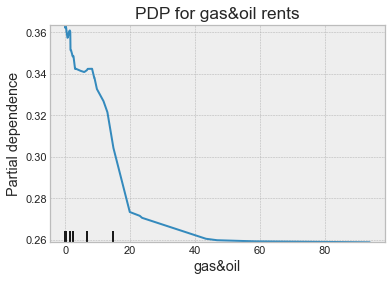

In [58]:
y_plots = plot_partial_dependence(rf,       
                                   features=['gas&oil'],
                                   X=X_train, 
                                   feature_names=['polityIV', 'EU', 'Gallup', 'trust', 'island', 'GDP', 'GDP_pc',
                                   'gas&oil', 'coal_elec']) 

plt.title('PDP for gas&oil rents');

plt.savefig("gas&oil",bbox_inches='tight', dpi=200)

#plt.xlim(0, 1000) - Zoom in # plt.xticks(np.arange()) 



In [ ]:
plt.style.use('bmh')

pdp_goals = pdp.pdp_isolate(model=rf, dataset=X_train, model_features=X_train.columns, feature='Gallup')

pdp.pdp_plot(pdp_goals, 'Gallup')

plt.ylabel("CLIMI")

plt.show()

plt.savefig("gallup_")

In [ ]:
pdp_goals = pdp.pdp_isolate(model=rf, dataset=X_train, model_features=X_train.columns, feature='polityIV')

pdp.pdp_plot(pdp_goals, 'polityIV')

plt.ylabel("CLIMI")

plt.show()

plt.savefig("polityIV_")

In [ ]:
# Interaction terms with 2D PDP

# Similar to previous PDP plot except I use pdp_interact instead of pdp_isolate and pdp_interact_plot instead of pdp_isolate_plot

features_to_plot = ['GGallup', 'PolityIV]

inter1  =  pdp.pdp_interact(model=rf, dataset= X_train, model_features=X_train.columns, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')

plt.show()